In [10]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta


In [2]:
USERNAME = "spmcadam57@gmail.com"
PASSWORD = "PASSWORD"

LOGIN_URL = "https://www.space-track.org/ajaxauth/login"

with requests.Session() as session:
    # 1) Log in
    login_data = {
        "identity": USERNAME,
        "password": PASSWORD
    }
    login_resp = session.post(LOGIN_URL, data=login_data)
    login_resp.raise_for_status()
    
    # 2) Perform the query
    query_url = "https://www.space-track.org/basicspacedata/query/class/gp/EPOCH/%3Enow-30/MEAN_MOTION/%3E11.25/ECCENTRICITY/%3C0.25/OBJECT_TYPE/payload/orderby/NORAD_CAT_ID,EPOCH/format/3le"
    resp = session.get(query_url)
    resp.raise_for_status()
    
    # 3) Check the response
    tle_text = resp.text
    print(tle_text)


0 VANGUARD 2
1 00011U 59001A   25024.89926981  .00001715  00000-0  91346-3 0  9992
2 00011  32.8617 207.3877 1451491  46.4503 324.7844 11.89110103474903
0 VANGUARD 3
1 00020U 59007A   25024.44314442  .00001626  00000-0  64140-3 0  9995
2 00020  33.3498 296.3637 1644908 209.4790 140.2261 11.60370079425464
0 EXPLORER 7
1 00022U 59009A   25024.61462825  .00019215  00000-0  91188-3 0  9992
2 00022  50.2768  68.4197 0099081 256.6470 102.3423 15.14940994722884
0 TIROS 1
1 00029U 60002B   25024.89954679  .00001841  00000-0  28349-3 0  9992
2 00029  48.3774 278.2338 0022897 240.3112 119.5521 14.77537004466930
0 TRANSIT 2A
1 00045U 60007A   25024.89817456  .00000716  00000-0  20155-3 0  9993
2 00045  66.6929 264.0186 0249605 171.8650 188.6620 14.35291952307080
0 SOLRAD 1 (GREB)
1 00046U 60007B   25024.74659506  .00002329  00000-0  44521-3 0  9993
2 00046  66.6890 173.0357 0204032 313.7670  44.6708 14.53411568383079
0 COURIER 1B
1    58U 60013A   25024.55525940  .00000130  00000-0  68160-4 0  99

In [3]:
def parse_tle_to_dataframe(tle_text):
    """
    Parses TLE data in 3-line format (0/1/2) into a pandas DataFrame.
    
    Parameters:
        tle_text (str): Raw TLE data as a string.
    
    Returns:
        pd.DataFrame: DataFrame containing TLE data with columns ["Name", "Line1", "Line2"].
    """
    # Split the text into individual lines and remove any empty lines
    lines = [line.strip() for line in tle_text.strip().splitlines() if line.strip()]
    
    # Initialize a list to hold satellite data
    satellites = []
    
    # Check if the number of lines is a multiple of 3
    if len(lines) % 3 != 0:
        print("Warning: The number of lines is not a multiple of 3. Some TLE entries may be incomplete.")
    
    # Iterate over the lines in steps of 3
    for i in range(0, len(lines) - 2, 3):
        name_line = lines[i]
        line1 = lines[i + 1]
        line2 = lines[i + 2]
        
        # Validate line prefixes
        if not name_line.startswith("0"):
            print(f"Unexpected format in name line: '{name_line}'. Skipping this entry.")
            continue
        if not line1.startswith("1"):
            print(f"Unexpected format in Line 1: '{line1}'. Skipping this entry.")
            continue
        if not line2.startswith("2"):
            print(f"Unexpected format in Line 2: '{line2}'. Skipping this entry.")
            continue
        
        # Extract the satellite name by removing the leading "0" and any whitespace
        name = name_line[1:].strip()
        
        # Append the data to the list
        satellites.append({
            "Name": name,
            "Line1": line1,
            "Line2": line2
        })
    
    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(satellites, columns=["Name", "Line1", "Line2"])
    
    return df


# Parse the TLE text into a DataFrame
tle_df = parse_tle_to_dataframe(tle_text)

# Display the DataFrame
print(tle_df)
print(f"Number of satellites parsed: {len(tle_df)}")

                 Name                                              Line1  \
0          VANGUARD 2  1 00011U 59001A   25024.89926981  .00001715  0...   
1          VANGUARD 3  1 00020U 59007A   25024.44314442  .00001626  0...   
2          EXPLORER 7  1 00022U 59009A   25024.61462825  .00019215  0...   
3             TIROS 1  1 00029U 60002B   25024.89954679  .00001841  0...   
4          TRANSIT 2A  1 00045U 60007A   25024.89817456  .00000716  0...   
...               ...                                                ...   
11355  STARLINK-32778  1 62603U 25008S   25024.91667824 -.01133564  0...   
11356  STARLINK-32710  1 62604U 25008T   25024.91667824 -.01141772  0...   
11357  STARLINK-32742  1 62605U 25008U   25024.91667824 -.01150225  0...   
11358  STARLINK-32783  1 62606U 25008V   25024.91667824 -.01161682  0...   
11359  STARLINK-32784  1 62607U 25008W   25024.91667824 -.01162271  0...   

                                                   Line2  
0      2 00011  32.8617 207.

In [5]:
def extract_launch_year(line1):
    """
    Extracts the launch year from TLE Line1.

    Parameters:
        line1 (str): TLE Line1 string.

    Returns:
        int or None: Four-digit launch year or None if extraction fails.
    """
    try:
        parts = line1.split()
        # International Designator is the 4th field (index 2)
        int_designator = parts[2]
        # First two characters represent the launch year (YY)
        yy = int_designator[:2]
        
        # Convert YY to full year
        yy = int(yy)
        if yy >= 57:
            year = 1900 + yy
        else:
            year = 2000 + yy
        return year
    except (IndexError, ValueError) as e:
        # In case of unexpected format or missing fields
        print(f"Error extracting launch year from Line1: '{line1}'. Error: {e}")
        return None
    
tle_df['Launch Year'] = tle_df['Line1'].apply(extract_launch_year)

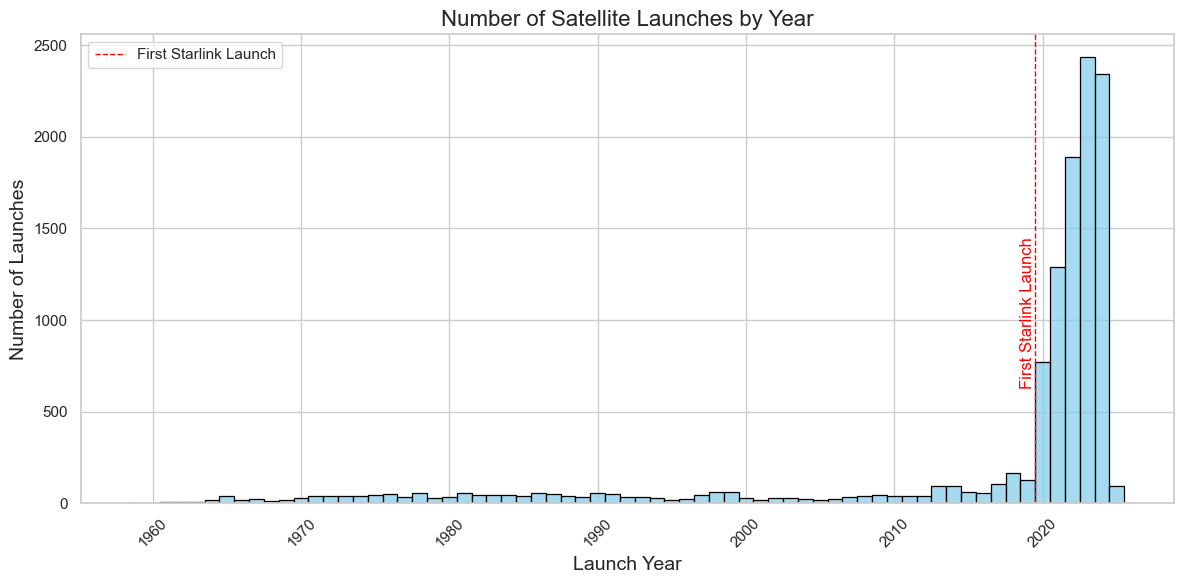

In [28]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

sns.histplot(
    data=tle_df,
    x='Launch Year',
    bins=range(tle_df['Launch Year'].min(), tle_df['Launch Year'].max() + 2),  # +2 to include the last year
    discrete=True,
    kde=False,
    color='skyblue',
    edgecolor='black'
)

plt.title('Number of Satellite Launches by Year', fontsize=16)
plt.xlabel('Launch Year', fontsize=14)
plt.ylabel('Number of Launches', fontsize=14)

plt.axvline(x=2019.45, color='red', linestyle='--', label='First Starlink Launch', linewidth='1')
plt.annotate(
    'First Starlink Launch',
    xy=(2019.45, plt.ylim()[1] * 0.25),  # Point of the annotation (x, y)
    xytext=(2019.45 - 1, plt.ylim()[1] * 0.25),  # Text location (x, y)
    color='red',
    fontsize=12,
    rotation=90,
)

#plt.yscale('log')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()